# 1. Libraries

In [21]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson
from scipy.stats import kurtosis
from hmmlearn import hmm
import matplotlib.patches as mpatches
from scipy.stats import wasserstein_distance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# 2. Load Data

In [2]:
filepath = "../data/"

train_df = pd.read_parquet(filepath+"train.parquet")
# test_df = pd.read_parquet(filepath+"test.parquet")

In [3]:
print("Missing values in 'label':", train_df['label'].isna().sum())

if isinstance(train_df.index, pd.DatetimeIndex):
    is_sorted = train_df.index.is_monotonic_increasing
    is_unique = train_df.index.is_unique
    print(f"Index is datetime: True | Sorted: {is_sorted} | Unique: {is_unique}")
else:
    print("Index is not a DatetimeIndex.")

Missing values in 'label': 0
Index is datetime: True | Sorted: True | Unique: True


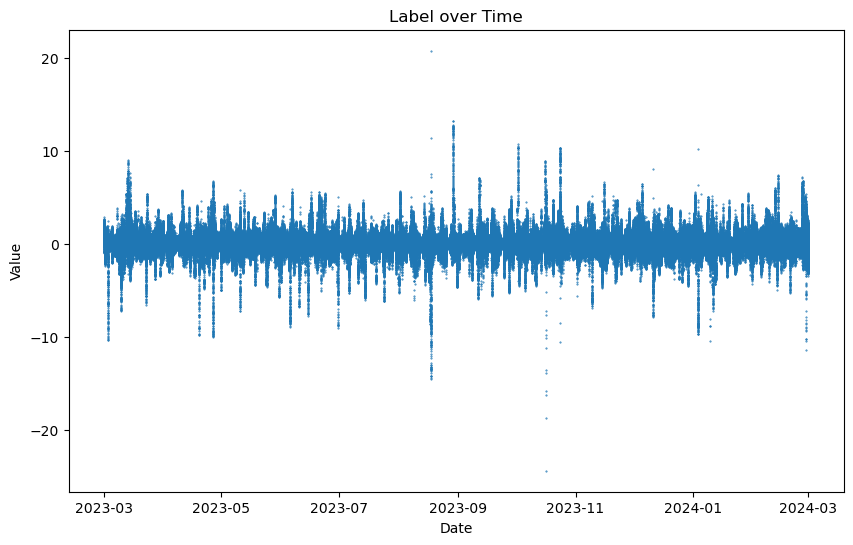

In [4]:
plt.figure(figsize=(10, 6))

plt.scatter(x=train_df.index, y=train_df['label'], s=0.2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Label over Time')

plt.show()

# 3. Target Distribution Analysis

## 3.1 Descriptive Statistics  

- The target variable is relatively centered around zero, with a mean of **0.03**, indicating low bias prior to standardization. However, the standard deviation of approximately **1.0** reflects substantial dispersion.  

- This contrast is especially apparent when compared to the **narrow 95% confidence interval for the mean**, indicating that the overall distribution must be highly variable.  

- The **minimum and maximum values of -24 and 20**, respectively, further underscore the presence of extreme values and heavy tails. This pattern is consistent with a distribution closer to a **Student's t** or even **Cauchy**, rather than a standard Gaussian.

In [5]:
mean = train_df['label'].mean()
median = train_df['label'].median()
skew = train_df['label'].skew()
std = train_df['label'].std()

print(f"Target Mean: {mean}")
print(f"Target Median: {median}")
print(f"Target Standard Deviation: {std}")
print(f"Target Skew: {skew}")

z = 1.96  # or use t-score if n is small
stderr = std / np.sqrt(len(train_df))
ci_lower = mean - z * stderr
ci_upper = mean + z * stderr

print(f"95% CI for Mean (Assuming Normality): [{ci_lower:.4f}, {ci_upper:.4f}]")

train_df['label'].describe()

Target Mean: 0.03612583479917426
Target Median: 0.016260691207415537
Target Standard Deviation: 1.0099145156502942
Target Skew: -0.11348704299677286
95% CI for Mean (Assuming Normality): [0.0334, 0.0389]


count    525886.000000
mean          0.036126
std           1.009915
min         -24.416615
25%          -0.381586
50%           0.016261
75%           0.434137
max          20.740270
Name: label, dtype: float64

## 3.2 Initial Plots  

- The boxplots, histograms, and KDE plots reflect the same key trends observed in the descriptive statistics: a strong concentration of values around **0** and the **mean**, but with a significant number of extreme outliers.  

- Even in the **clipped plots**, we see that our descriptive stats remain tightly clustered around the center, reinforcing the idea of a central tendency surrounded by heavy tails, as evidenced by our significant measures of dispersion.  

- The histogram and KDE also suggest **non-normality**, with tails that extend far beyond what would be expected under a Gaussian distribution—consistent with the earlier observation that the data may be better modeled by a **heavy-tailed distribution**.

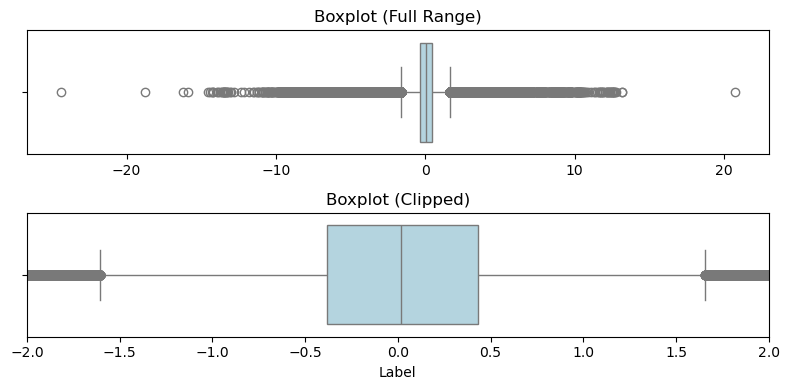

In [6]:
plt.figure(figsize=(8, 4))

plt.subplot(2, 1, 1)
sns.boxplot(x=train_df['label'], color='lightblue')
plt.title("Boxplot (Full Range)")
plt.xlabel("")

plt.subplot(2, 1, 2)
sns.boxplot(x=train_df['label'], color='lightblue')
plt.xlim(-2, 2)
plt.title("Boxplot (Clipped)")
plt.xlabel("Label")

plt.tight_layout()
plt.show()


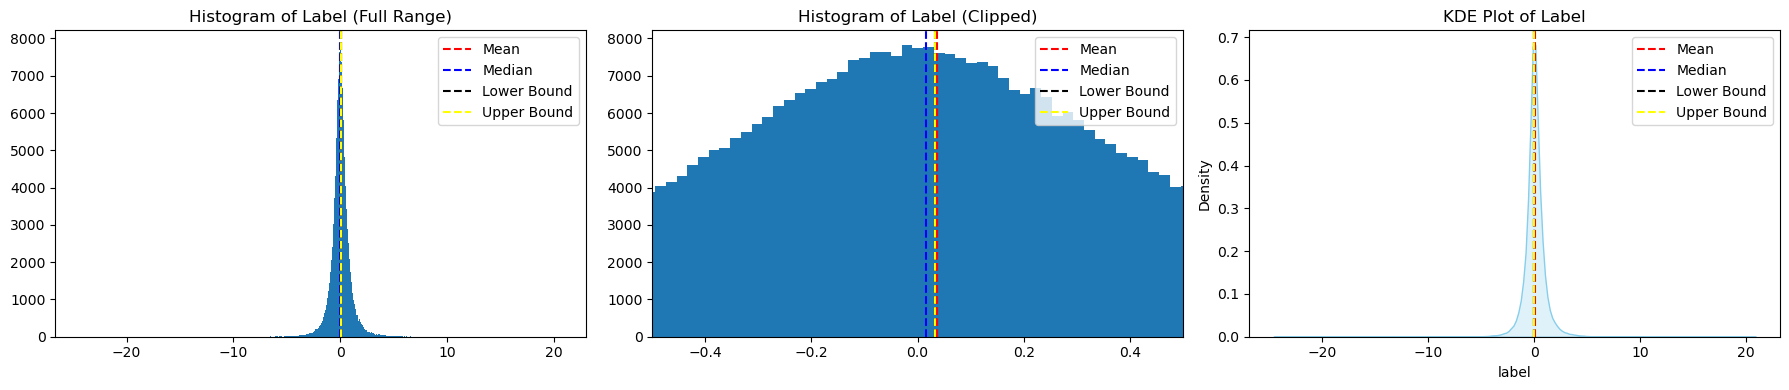

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(train_df['label'], bins='auto')
axes[0].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[0].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[0].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[0].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[0].set_title("Histogram of Label (Full Range)")
axes[0].legend()

axes[1].hist(train_df['label'], bins='auto')
axes[1].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[1].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[1].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[1].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[1].set_xlim(-0.5, 0.5)
axes[1].set_title("Histogram of Label (Clipped)")
axes[1].legend()

sns.kdeplot(train_df['label'], ax=axes[2], fill=True, color='skyblue')
axes[2].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[2].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[2].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[2].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[2].set_title("KDE Plot of Label")
axes[2].legend()

plt.tight_layout()
plt.show()

## 3.3 Distribution Analysis

### 3.3.1 Normality Analysis

- Formal normality tests (Shapiro-Wilk, D’Agostino’s K², and Anderson-Darling) yield p-values well above typical thresholds (e.g., 0.05). However, due to the extremely large sample size (~500,000), these results may not be reliable asthe tests can become overly sensitive or inaccurate at this scale.

- Despite high p-values, visual evidence from the Q-Q plot strongly suggests **non-normality**. We observe heavy tails and slight skewness, consistent with the descriptive statistics and histograms.

- Taken together, these indicators point toward a **departure from Gaussian behavior**, likely driven by outliers, kurtosis, and potential skew. This may be suggesting a distribution more aligned with heavy-tailed families like the Student-t or Cauchy.

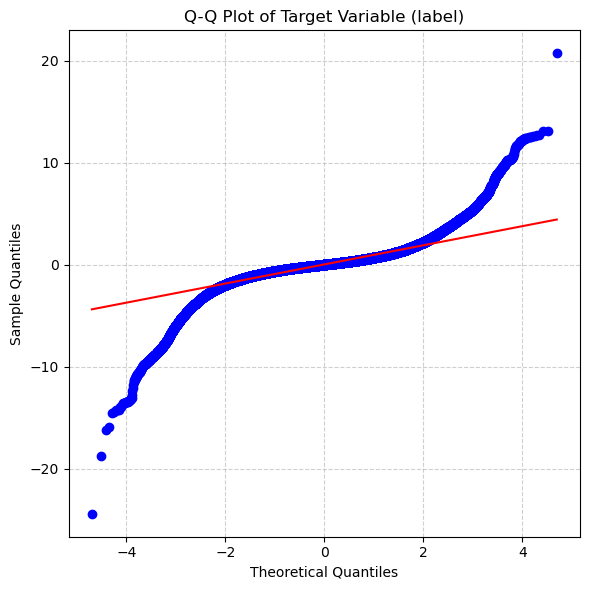

Kurtosis: 15.991546355483528
Skew: -0.11348704299677286
Shapiro-Wilk Test:      stat = 0.8627, p-value = 0.0000e+00
D’Agostino-Pearson Test: stat = 116907.3714, p-value = 0.0000e+00
Anderson-Darling Test:   stat = 14013.8673
  15% level: crit = 0.5760 → Reject H0
  10% level: crit = 0.6560 → Reject H0
  5% level: crit = 0.7870 → Reject H0
  2% level: crit = 0.9180 → Reject H0
  1% level: crit = 1.0920 → Reject H0


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [8]:
plt.figure(figsize=(6, 6))
stats.probplot(train_df['label'], dist="norm", plot=plt)

plt.title("Q-Q Plot of Target Variable (label)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Kurtosis:", kurtosis(train_df['label']))
print("Skew:", skew)

shapiro_stat, shapiro_p = shapiro(train_df['label'])
print(f"Shapiro-Wilk Test:      stat = {shapiro_stat:.4f}, p-value = {shapiro_p:.4e}")
dagostino_stat, dagostino_p = normaltest(train_df['label'])
print(f"D’Agostino-Pearson Test: stat = {dagostino_stat:.4f}, p-value = {dagostino_p:.4e}")
anderson_result = anderson(train_df['label'], dist='norm')
print(f"Anderson-Darling Test:   stat = {anderson_result.statistic:.4f}")
for i in range(len(anderson_result.critical_values)):
    cv = anderson_result.critical_values[i]
    sl = anderson_result.significance_level[i]
    result = "Reject" if anderson_result.statistic > cv else "Fail to Reject"
    print(f"  {sl:.0f}% level: crit = {cv:.4f} → {result} H0")

### 3.3.2 Distribution Testing

- The data exhibits pronounced heavy tails, prompting evaluation against heavy-tailed distributions.

- We tested the fit against Student’s t-distribution and Cauchy distribution using the Kolmogorov-Smirnov (K-S) test:

- The Student’s t-distribution provides a significantly better fit than the Cauchy distribution and also outperforms the normal distribution (tested separately).

- While the true underlying population may not be exactly t-distributed, this insight informs our modeling approach.

- Robust loss functions such as Huber loss, Tweedie loss, or quantile regression could improve model robustness to outliers.

- Alternatively, preprocessing methods like removing or down-weighting extreme outliers may be beneficial.

- Incorporating anomaly detection or scoring methods to identify extreme observations can further enhance predictive performance and robustness.

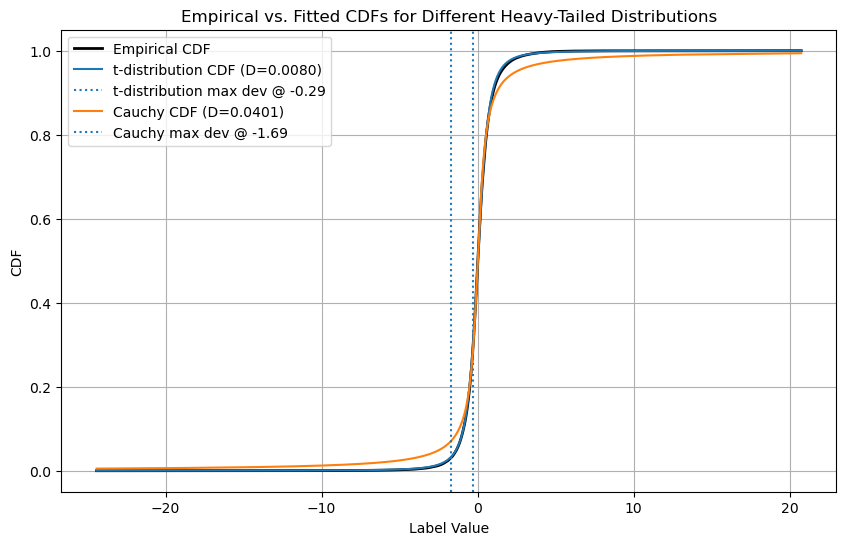

Kolmogorov-Smirnov test results:
t-distribution:   D = 0.008040, p = 5.956e-30
Cauchy:          D = 0.040135, p = 0.000e+00


In [9]:
from scipy.stats import t, cauchy, kstest

data = train_df['label'].dropna().sort_values()
n = len(data)
ecdf = np.arange(1, n + 1) / n

t_params = t.fit(data)
cauchy_params = cauchy.fit(data)

cdf_t = t.cdf(data, *t_params)
cdf_cauchy = cauchy.cdf(data, *cauchy_params)

ks_t = kstest(data, 't', args=t_params)
ks_cauchy = kstest(data, 'cauchy', args=cauchy_params)

plt.figure(figsize=(10, 6))
plt.plot(data, ecdf, label='Empirical CDF', color='black', lw=2)

for name, cdf, ks in zip(
    ['t-distribution', 'Cauchy'],
    [cdf_t, cdf_cauchy],
    [ks_t, ks_cauchy]
):
    plt.plot(data, cdf, label=f"{name} CDF (D={ks.statistic:.4f})")
    plt.axvline(ks.statistic_location, linestyle=':', 
                label=f"{name} max dev @ {ks.statistic_location:.2f}")

plt.title('Empirical vs. Fitted CDFs for Different Heavy-Tailed Distributions')
plt.xlabel('Label Value')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

print("Kolmogorov-Smirnov test results:")
print(f"t-distribution:   D = {ks_t.statistic:.6f}, p = {ks_t.pvalue:.3e}")
print(f"Cauchy:          D = {ks_cauchy.statistic:.6f}, p = {ks_cauchy.pvalue:.3e}")

# 4. Regime Exploration

## 4.1 Rolling Standard Deviation
- The rolling standard deviation plot reveals periods of high and low volatility, these dynamic and sudden changes in market behavior that may not be fully captured by the existing feature set. 

- By averaging the rolling volatility calculated over multiple window lengths, we obtain a smoothed measure that reflects overall volatility trends more robustly.

- These fluctuations in volatility strongly suggest the presence of **volatility regimes**, which are persistent states characterized by differing levels of market turbulence or calm. 

- Identifying and incorporating these volatility regimes as features can enhance downstream models by capturing nonlinear effects and regime-dependent behaviors that simpler metrics might miss.

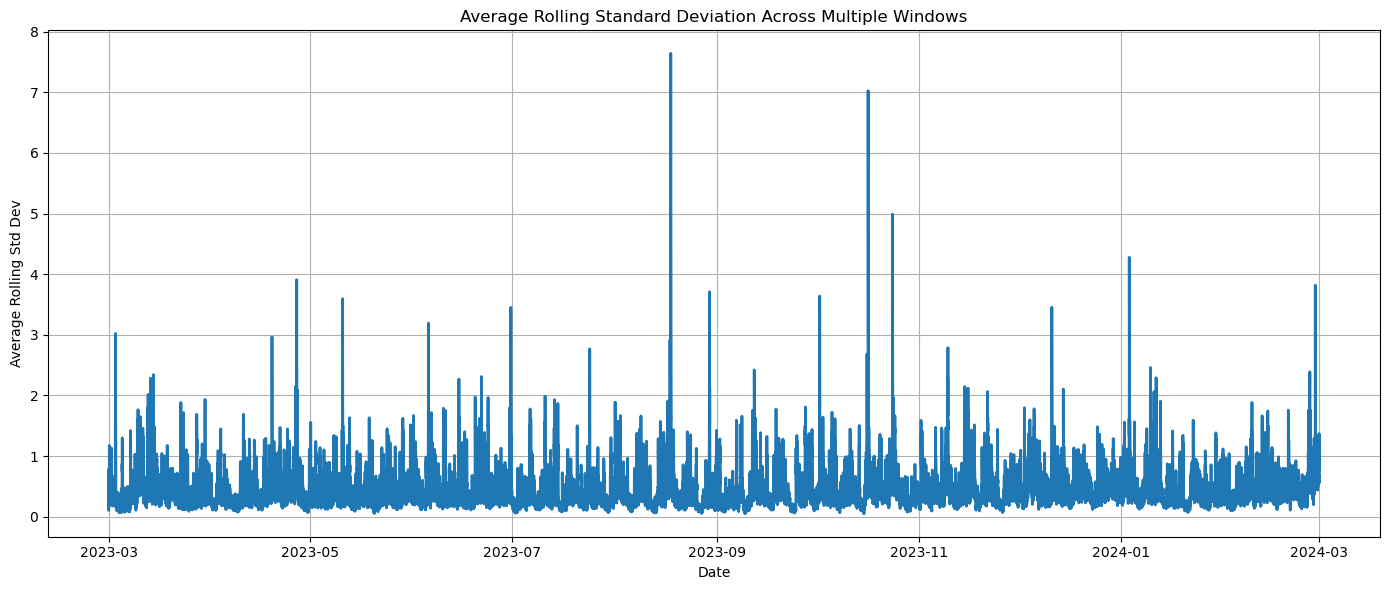

In [10]:
label = train_df['label']
windows = [20, 50, 100, 200]
rolling_vols = pd.DataFrame(index=label.index)

for w in windows:
    rolling_vols[f'rolling_std_{w}'] = label.rolling(window=w).std()

rolling_vols['average_rolling_std'] = rolling_vols.mean(axis=1)

plt.figure(figsize=(14, 6))
plt.plot(rolling_vols.index, rolling_vols['average_rolling_std'], linewidth=2)
plt.title('Average Rolling Standard Deviation Across Multiple Windows')
plt.xlabel('Date')
plt.ylabel('Average Rolling Std Dev')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.2 Hidden Markov Model

- To identify  volatility regimes, we use a Hidden Markov Model (HMM). This model is well suited for our task because it captures the sequential nature of market data by modeling hidden states that evolve over time with probabilistic transitions. Unlike clustering methods, HMM accounts for temporal dependencies and regime persistence, providing a more realistic representation of market behavior, and is generally better in a time-dependent case like orus.

- Our HMM analysis revealed four distinct volatility regimes, each with unique statistical properties in terms of mean and variance. The model demonstrated strong performance in segmenting the data into these regimes, supported by clear differences in the distributions and meaningful transition probabilities that reflect realistic regime switching behavior.

- The identified regimes could serve as valuable signals in downstream modeling, as they capture nonlinear effects and shifts in market dynamics that are otherwise difficult to detect using standard features alone.

- However, since the test data lacks timestamps, directly applying these regime labels is not possible. To actually use these signals effectively, we need to build a predictive model that predicts market regimes from available features and can then be applied to the test data.

In [11]:
data = train_df['label'].dropna().values.reshape(-1, 1)

model = hmm.GaussianHMM(n_components=4, covariance_type='full', n_iter=1000, random_state=42)
model.fit(data)

states = model.predict(data)
df_states = pd.DataFrame({'label': data.flatten(), 'state': states})

           mean       std   count        min        max
state                                                  
0     -0.581384  0.267818  131052  -1.810094   0.531297
1      0.005067  0.167629  186202  -0.638395   0.674296
2      0.600902  0.266216  133782  -0.502046   1.765221
3      0.185121  2.362506   74850 -24.416615  20.740270
Transition matrix:
[[9.56340251e-01 3.54494482e-02 3.72646355e-04 7.83765437e-03]
 [2.55192366e-02 9.48564069e-01 2.59166945e-02 1.11954588e-38]
 [2.93775098e-04 3.58952092e-02 9.55629263e-01 8.18175290e-03]
 [1.32277502e-02 6.78241174e-21 1.49163311e-02 9.71855919e-01]]
Wasserstein distance between state 0 and 1: 0.5865
Wasserstein distance between state 0 and 2: 1.1823
Wasserstein distance between state 0 and 3: 1.8810
Wasserstein distance between state 1 and 2: 0.5958
Wasserstein distance between state 1 and 3: 1.9110
Wasserstein distance between state 2 and 3: 1.7915


/var/folders/f9/6rcv_50n3nddl9gbvsc0y3br0000gn/T/ipykernel_3481/2166876623.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', model.n_components)


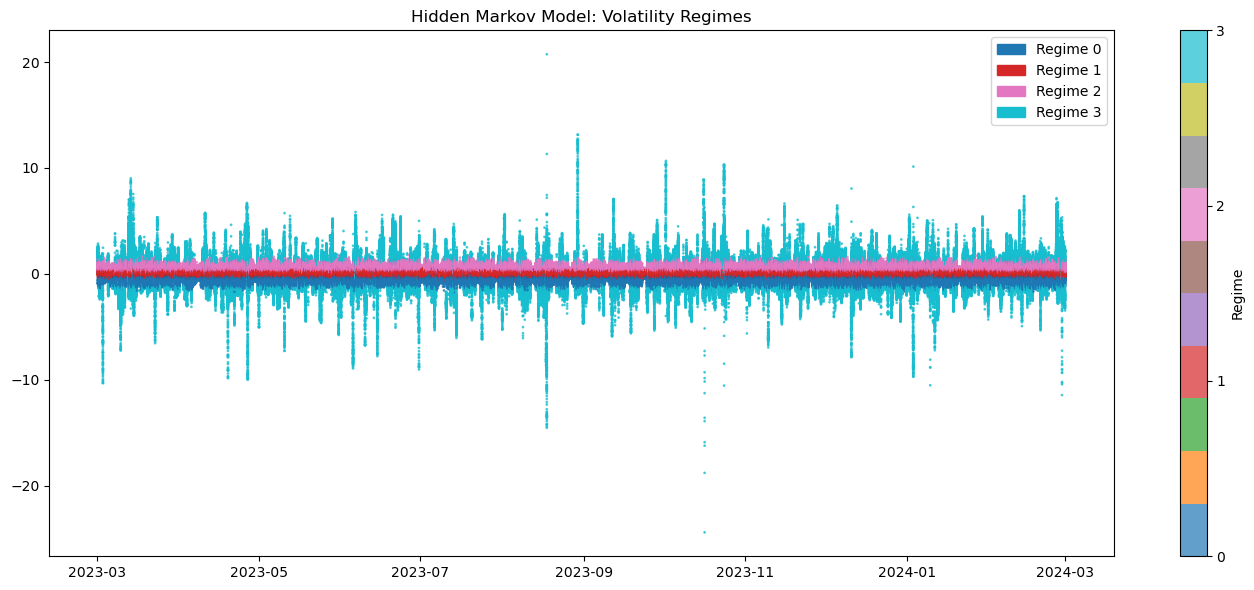

In [12]:
df_states = pd.DataFrame({'label': data.flatten(), 'state': states})

state_summary = df_states.groupby('state')['label'].agg(['mean', 'std', 'count', 'min', 'max'])
print(state_summary)
print("Transition matrix:")
print(model.transmat_)

state_values = [df_states[df_states['state'] == s]['label'].values for s in sorted(df_states['state'].unique())]

for i in range(len(state_values)):
    for j in range(i + 1, len(state_values)):
        dist = wasserstein_distance(state_values[i], state_values[j])
        print(f"Wasserstein distance between state {i} and {j}: {dist:.4f}")

x_vals = train_df.index[-len(states):]
y_vals = data.flatten()

train_df['hmm_states'] = df_states['state'].values

plt.figure(figsize=(14, 6))
scatter = plt.scatter(x_vals, y_vals, c=states, cmap='tab10', alpha=0.7, s=1)
plt.colorbar(scatter, ticks=range(model.n_components), label='Regime')

cmap = plt.cm.get_cmap('tab10', model.n_components)
handles = [mpatches.Patch(color=cmap(i), label=f'Regime {i}') for i in range(model.n_components)]
plt.legend(handles=handles)

plt.title('Hidden Markov Model: Volatility Regimes')
plt.tight_layout()
plt.show()

# 5. Reverse Classification + Modeling

## 5.1 Proof of Concept Run

- We attempted to classify regimes using feature data **without including datetime information**.  

- Our **logistic regression model showed limited performance**, achieving a macro-average recall of **0.43** and accuracy of **0.46**.  

- In contrast, the **random forest classifier performed substantially better**, achieving a macro-average recall of **0.91** and accuracy of **0.90**.  

- These results demonstrate the strong potential to predict regime labels from feature data alone.  

- If these regime labels prove useful for long-term prediction tasks, the classification model outputs on the test set can be incorporated as additional features in downstream predictive models to improve performance further.

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(train_df.drop(['label', 'hmm_states'], axis=1))
y = train_df['hmm_states']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
log_model = LogisticRegression(solver='lbfgs', max_iter=800, verbose=1)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
print(classification_report(y_test, y_pred))

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     26427
           1       0.92      0.86      0.89     37109
           2       0.89      0.92      0.90     26667
           3       0.91      0.96      0.93     14975

    accuracy                           0.90    105178
   macro avg       0.90      0.91      0.91    105178
weighted avg       0.90      0.90      0.90    105178



# 6. Summary & Next Steps

## What We Learned
- The label dataframe is clean, with no missing values and no duplicate datetime entries.  
- The label has a mean of approximately 0.03 with a slight negative skew.  
- It exhibits a relatively large standard deviation of 1.0, which contrasts sharply with the naive 95% confidence interval between 0.0334 and 0.0389.  
- Visualizations show most data points are tightly clustered near the center but with very heavy tails, indicating strong non-normality.  
- Distribution tests suggest the label resembles a t-distribution with around 2.35 degrees of freedom.  
- We estimated volatility regimes using Hidden Markov Models (HMMs) to capture time-dependent and nonlinear regime effects.  
- Using these regime labels, we achieved high accuracy with a random forest classifier. Pending further validation, these regime features will be incorporated into our time-agnostic scored test set.

## Plan
- Since the label data is clean, no additional preprocessing is required on that front.  
- The heavy-tailed nature of the label suggests that standard scaling may compress the majority of data excessively. More robust loss functions, such as Huber or Quantile loss, might be necessary.  
- Based on feature importance from the HMM regime classifications, we are confident in incorporating volatility regimes as features moving forward.  
- The heavy tails may influence model selection, encouraging the use of more robust or ensemble methods to better capture diverse data behaviors.